## Librerias

Se importan las librerías necesarias.

In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from numpy.core.numeric import zeros_like
import operator

## Funciones

Como en este script se pretende hacer uso de diferentes algoritmos y encontrar el que mejor se adecue a la base de datos. En este sentido las funciones son agrupadas por tipo de algoritmo.

### PCA

In [4]:
def covarianza(x_, y_):
  x_media_ = x_.mean()
  y_media_ = y_.mean()
  n = len(x_)
  covar = (((x_ - x_media_) * (y_ - y_media_)).sum()) / (n - 1)
  return covar

In [5]:
def matriz_covarianza(datos_):
  atributos_ = datos_.columns
  n_ = len(atributos_)
  matriz_ = np.zeros((n_, n_))
  for i, atr_i in enumerate(atributos_):
    for j, atr_j in enumerate(atributos_):
      xmc_ = datos_[atr_i]
      ymc_ = datos_[atr_j]
      matriz_[i, j] = covarianza(xmc_, ymc_)
  return matriz_

### KNN

In [6]:
def distancia_euclidiana(puntos_, c_):
  n_ = len(puntos_)
  de_ = np.zeros(n_)
  for p in range(n_):
    suma_cuadrados_ = sum((puntos_[p] - c_) ** 2)
    de_[p] = np.sqrt(suma_cuadrados_)
  de_ = pd.DataFrame(de_)
  return de_

In [7]:
# Entrenar
def entrenamiento_KNN(x_ent_, y_ent_, k_max_):
  numero_clases_ = len(np.unique(y_ent_))
  n_ = len(x_ent_)
  exactitudes_ = np.zeros(k_max_ - numero_clases_)
  for i in tqdm(range(numero_clases_ + 1, k_max_ + 1)):
    y_clas_train_ = np.zeros(n_)
    for j in range(n_):
      distancias_p_ = distancia_euclidiana(x_ent_, x_ent_[j])
      y_clas_train_[j] = pertenencia(distancias_p_, y_ent_, i)
    exactitudes_[i - k_max_ - 1] = exactitud(y_clas_train_, y_ent_)
  #print(exactitudes_)
  max_exactitud_ = max(exactitudes_)
  #print(max_exactitud_)
  indices_ = np.where(exactitudes_ == max_exactitud_)
  #print(indices_)
  if len(indices_[0]) > 1: indices_ = indices_[0]
  indices_ = int(indices_[0])
  mejores_vecinos_ = indices_ + numero_clases_ + 1
  return exactitudes_, max_exactitud_, mejores_vecinos_

In [8]:
def pertenencia(distancias_, Y_, k_):
  distancias_min_max_ = distancias_.sort_values(0)
  vecinos_cercanos_ = distancias_min_max_.index.values[1:k_ + 1]
  Y_vecinos_ = Y_[vecinos_cercanos_].tolist()
  y_clasificacion_ = np.bincount(Y_vecinos_).argmax()
  return y_clasificacion_

In [9]:
def clasificar_KNN(x_test_, x_train_, y_train_, k_):
  n_ = len(x_test_)
  y_clas_ = np.zeros(n_)
  for i in tqdm(range(n_)):
    distancias_p_ = distancia_euclidiana(x_train_, x_test_[i])
    y_clas_[i] = pertenencia(distancias_p_, y_train_, k_)
  return y_clas_

### ID3

In [10]:
def contar_clases(atributo_decision_, clases_):
    cont_clases_ = np.zeros((len(clases_)))
    for n, c in enumerate(clases_):
        cont_clases_[n] = int(np.sum(atributo_decision_ == c))
    return cont_clases_

In [11]:
def calcular_entropia(cont_clases_):
    entropia_decision_ = 0
    total = int(sum(cont_clases_))
    for d in cont_clases_:
        if d == 0: entropia_decision_ += 0
        else: entropia_decision_ -= (d/total)*np.log2(d/total)
    return entropia_decision_

In [12]:
def ganancia_atributo(x_, y_, cont_clases_, entropia_, clases_):
    Total_ = int(sum(cont_clases_))
    ganancias_ = {}
    for a in x_.columns:
        ganancias_[a] = 0
        observaciones = x_[a].unique()
        for o in observaciones:
            y_a_o_ = y_.loc[x_[a] == o]
            cont_clases_y_a_o_ = contar_clases(y_a_o_, clases_)
            entropia_a_o_ = calcular_entropia(cont_clases_y_a_o_)
            total_ = int(sum(cont_clases_y_a_o_))
            ganancias_[a] += (total_/Total_) * entropia_a_o_
        ganancias_[a] = entropia_ - ganancias_[a]
    return ganancias_

In [13]:
def nodo_raiz(ganancias_):
    raiz_ = max(ganancias_.items(), key=operator.itemgetter(1))[0]
    entropia_r_ = ganancias_[raiz_]
    return raiz_, entropia_r_

In [14]:
def nodos_intermedios(x_, y_, atributo_, obs_):
    subx_ = []
    suby_ = []
    for o in obs_:
        pos_coinciden_ = x_[atributo_] == o
        subx_.append(x_.loc[pos_coinciden_])
        suby_.append(y_.loc[pos_coinciden_])
    return subx_, suby_

In [15]:
def fin_rama(y_fr_, obs_):
    hoja_ = 0
    clase_fr_ = 0
    n = len(y_fr_)
    for o in obs_:
        coincidencias_ = int(np.sum(y_fr_ == o))
        if coincidencias_ == n:
            hoja_ = 1
            clase_fr_ = o
    return hoja_, clase_fr_

In [16]:
def arbol_id3(x_, y_, clases_, arbol_):
    conteo_clases = contar_clases(y_, clases_)
    entropia_decision_ = calcular_entropia(conteo_clases)
    ganancias_ = ganancia_atributo(x_, y_, conteo_clases, 
                                   entropia_decision_, clases_)
    nodo_raiz_, entropia_raiz_ = nodo_raiz(ganancias_)
    arbol_[nodo_raiz_] = {}
    ramas_ = x_[nodo_raiz_].unique()
    sub_x_, sub_y_ = nodos_intermedios(x_, y_, nodo_raiz_, ramas_)
    for r, sx, sy in zip(ramas_, sub_x_, sub_y_):
        arbol_[nodo_raiz_][r] = {}
        hoja_, clase_f_ = fin_rama(sy, clases_)
        if hoja_ == 1:
            arbol_[nodo_raiz_][r] = clase_f_
        else:
            arbol_id3(sx, sy, clases_, arbol_[nodo_raiz_][r])
    return arbol_

In [17]:
def clasificar_id3(x_):
  indices_ = x_.index
  clasificaciones_ = []
  for i in indices_:
    clasifica_ = x_.loc[i]
    resultado_i = clasificar_arbol(clasifica_)
    clasificaciones_.append(resultado_i)
  return clasificaciones_

### MLP

In [18]:
class capa_neuronal():
  def __init__(self, num_entradas, num_neuronas, funcion_activacion):
    self.funcion_activacion = funcion_activacion
    self.bias = np.random.rand(1, num_neuronas) * 2 - 1
    self.w = np.random.rand(num_entradas, num_neuronas) * 2 - 1

In [19]:
def compilar_red(neuronas_por_capa, funcion_activacion):
  red_neuronal = []
  for n, capa in enumerate(neuronas_por_capa[:-1]):
    red_neuronal.append(capa_neuronal(neuronas_por_capa[n], neuronas_por_capa[n + 1], funcion_activacion))
  return red_neuronal

In [20]:
def entrenar_red(x, y, red_neuronal, sigmoide_derivada, l2_derivada):

  salidas = [(None, x)]
  for n, capa in enumerate(red_neuronal):
    I = np.dot(salidas[-1][1], red_neuronal[n].w) + red_neuronal[n].bias
    _y = red_neuronal[n].funcion_activacion(I)
    salidas.append((I, _y))

  deltas = []
  for n in reversed(range(0, len(red_neuronal))):
    I = salidas[n + 1][0]
    _y = salidas[n + 1][1]
    if n == len(red_neuronal) - 1:
      deltas.insert(0, l2_derivada(_y, y) * sigmoide_derivada(_y))
    else:
      deltas.insert(0, np.dot(deltas[0], _w.T) * sigmoide_derivada(_y))
      
    _w = red_neuronal[n].w

    red_neuronal[n].bias = red_neuronal[n].bias - (np.mean(deltas[0],
                                                        axis = 0,
                                                        keepdims = True) * 
                                             learning_rate)
    red_neuronal[n].w = red_neuronal[n].w - (np.dot(salidas[n][1].T, deltas[0]) *
                                             learning_rate) 
    
    return salidas[-1][1]

In [21]:
def predecir(x, red_neuronal):
  salidas = [(None, x)]
  for n, capa in enumerate(red_neuronal):
    I = np.dot(salidas[-1][1], red_neuronal[n].w) + red_neuronal[n].bias
    _y = red_neuronal[n].funcion_activacion(I)
    salidas.append((I, _y))
  return salidas[-1][1]

### Base de datos

In [22]:
def split_80_20(datos_, etiquetas_):
  n_ = len(datos_)
  indices_ = np.arange(n_)
  np.random.shuffle(indices_)
  lim = int(n_ * 0.80) + 1
  x_train_ = datos_[indices_[0:lim]]
  x_test_ = datos_[indices_[lim:]]
  y_train_ = etiquetas_[indices_[0:lim]]
  y_test_ = etiquetas_[indices_[lim:]]
  return x_train_, x_test_, y_train_, y_test_

In [23]:
def split_80_20_df(datos_, etiquetas_):
  n_ = len(datos_)
  indices_ = np.arange(n_)
  np.random.shuffle(indices_)
  lim = int(n_ * 0.80) + 1
  x_train_ = datos_.loc[indices_[0:lim]]
  x_test_ = datos_.loc[indices_[lim:]]
  y_train_ = etiquetas_.loc[indices_[0:lim]]
  y_test_ = etiquetas_.loc[indices_[lim:]]
  return x_train_, x_test_, y_train_, y_test_

In [24]:
def normalizar(df_):
    return (df_ - df_.min()) / ( df_.max() - df_.min())

### Cifras de mérito

In [25]:
def exactitud(y_calculada_, y_real_):
  coincidencias = np.equal(y_calculada_, y_real_)
  total_coin_ = np.sum(coincidencias)
  porcentaje_ = (total_coin_ / len(y_calculada_))
  return porcentaje_

In [26]:
def precision(y_clas_, y_real_):
  TP = 0
  FP = 0
  for c, r in zip(y_clas_, y_real_):
    if (r == c) and r == 1: TP += 1
    elif (r != c) and r == 0: FP += 1
  pre_ = TP / (TP + FP)
  return pre_

In [27]:
def precision_mlp(m_entrenamiento, m_esperada):
  m1 = np.round(m_entrenamiento)
  m1[:,0] = m1[:,0]*1000
  m1[:,1] = m1[:,1]*100
  #m1[:,2] = m1[:,2]*10
  m1 = np.sum(m1, axis=1)
  m2 = zeros_like(m_esperada)
  np.copyto(m2, m_esperada)
  m2[:,0] = m2[:,0]*1000
  m2[:,1] = m2[:,1]*100
  #m2[:,2] = m2[:,2]*10
  m2 = np.sum(m2, axis=1)
  errores = []
  for v1, v2 in zip(m1,m2):
    if v1 == v2: errores.append(0)
    else: errores.append(1)
  porcentaje = 100 * sum(errores) / len(errores)
  return sum(errores), porcentaje

In [28]:
def sensitividad(y_clas_, y_real_):
  TP_ = 0
  FN_ = 0
  for c, r in zip(y_clas_, y_real_):
    if (r == c) and r == 1: TP_ += 1
    elif (r != c) and r == 1: FN_ += 1
  sens_ = TP_ / (TP_ + FN_)
  return sens_

In [29]:
def especificidad(y_clas_, y_real_):
  TN_ = 0
  FP_ = 0
  for c, r in zip(y_clas_, y_real_):
    if (r == c) and r == 0: TN_ += 1
    elif (r != c) and r == 0: FP_ += 1
  esp_ = TN_ / (TN_ + FP_)
  return esp_

In [30]:
def puntaje_F1(y_clas_, y_real_):
  prec_ = precision(y_clas_, y_real_)
  sens_ = sensitividad(y_clas_, y_real_)
  pf1_ = 2 * ((prec_ * sens_) / (prec_ + sens_))
  return pf1_

In [31]:
def MSE(y_real_, y_clas_):
  l2 = np.sum((y_clas_ - y_real_)**2) / (2 * len(y_real_))
  return l2

## Base de datos

In [32]:
df = pd.read_csv('/content/drive/MyDrive/Bases_de_Datos/mushrooms.csv')
print("Dimensión:",df.shape)
df.head()

Dimensión: (8124, 23)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


### Análisis de la base de datos

In [33]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


Adicionalmente se elimina el atributo 'veil-type' ya que solamente cuenta con una observación.

In [34]:
df = df.drop(['veil-type'], axis = 1)

Se realiza un análisis mediante tres funciones diferentes para saber si la base de datos cuenta con datos faltantes.

In [35]:
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [37]:
df.isna().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

Para corroborar lo anterior se hace un análisis por columna, para ver si no existe alguna codificación que nos indique datos faltantes.

In [38]:
columnas = df.columns.values
elementos_columnas = {}

In [39]:
from pandas.core.algorithms import unique
for c in columnas:
  elementos_columnas[c] = df[c].unique()

In [40]:
elementos_columnas

{'bruises': array(['t', 'f'], dtype=object),
 'cap-color': array(['n', 'y', 'w', 'g', 'e', 'p', 'b', 'u', 'c', 'r'], dtype=object),
 'cap-shape': array(['x', 'b', 's', 'f', 'k', 'c'], dtype=object),
 'cap-surface': array(['s', 'y', 'f', 'g'], dtype=object),
 'class': array(['p', 'e'], dtype=object),
 'gill-attachment': array(['f', 'a'], dtype=object),
 'gill-color': array(['k', 'n', 'g', 'p', 'w', 'h', 'u', 'e', 'b', 'r', 'y', 'o'],
       dtype=object),
 'gill-size': array(['n', 'b'], dtype=object),
 'gill-spacing': array(['c', 'w'], dtype=object),
 'habitat': array(['u', 'g', 'm', 'd', 'p', 'w', 'l'], dtype=object),
 'odor': array(['p', 'a', 'l', 'n', 'f', 'c', 'y', 's', 'm'], dtype=object),
 'population': array(['s', 'n', 'a', 'v', 'y', 'c'], dtype=object),
 'ring-number': array(['o', 't', 'n'], dtype=object),
 'ring-type': array(['p', 'e', 'l', 'f', 'n'], dtype=object),
 'spore-print-color': array(['k', 'n', 'u', 'h', 'w', 'r', 'o', 'y', 'b'], dtype=object),
 'stalk-color-above-rin

Mediante el análisis anterior se encontro una codificación que nos indica datos faltantes en el atributo de 'stalk-root', los cuales son resaltados con el signo '?'. Por lo cual se cambian estos signos por valores NaN para poder realizar la pertinente imputación.

In [41]:
df['stalk-root'] = df['stalk-root'].replace('?', np.NaN)

Se contabilizan el número de datos faltantes para ver si el atributo que presenta los datos faltantes debe ser omitida o es viable realizar una imputación.

In [42]:
df.isnull().sum()/df.shape[0]*100

class                        0.000000
cap-shape                    0.000000
cap-surface                  0.000000
cap-color                    0.000000
bruises                      0.000000
odor                         0.000000
gill-attachment              0.000000
gill-spacing                 0.000000
gill-size                    0.000000
gill-color                   0.000000
stalk-shape                  0.000000
stalk-root                  30.526834
stalk-surface-above-ring     0.000000
stalk-surface-below-ring     0.000000
stalk-color-above-ring       0.000000
stalk-color-below-ring       0.000000
veil-color                   0.000000
ring-number                  0.000000
ring-type                    0.000000
spore-print-color            0.000000
population                   0.000000
habitat                      0.000000
dtype: float64

Se analiza la distribución del atributo para poder analizar la imputación y poder saber si no se alteraron significativamente los datos.

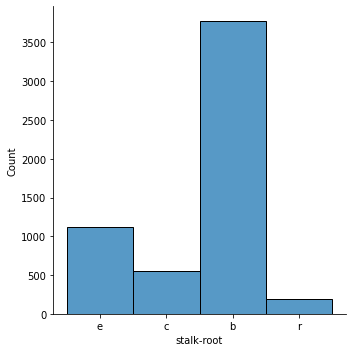

In [43]:
sns.displot(df['stalk-root'])

### Imputación

Para poder realizar la imputación de datos cambiamos los datos alfabeticos por númericos y proceder con la imputación por vecinos más cercanos.

In [44]:
df_n = df.copy()

In [102]:
for c in columnas:
  df_n[c] = df[c].replace(elementos_columnas[c],
                          np.arange(elementos_columnas[c].shape[0]))
  
df_n.head(10)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,1,1
2,1,1,0,2,0,2,0,0,1,1,...,0,0,0,0,0,0,0,1,1,2
3,0,0,1,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,3,1,3,0,1,1,0,...,0,0,0,0,0,0,1,1,2,1
5,1,0,1,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,1,1
6,1,1,0,2,0,1,0,0,1,2,...,0,0,0,0,0,0,0,0,1,2
7,1,1,1,2,0,2,0,0,1,1,...,0,0,0,0,0,0,0,1,0,2
8,0,0,1,2,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,3,1
9,1,1,0,1,0,1,0,0,1,2,...,0,0,0,0,0,0,0,0,0,2


In [46]:
np.max(df_n)

class                        1.0
cap-shape                    5.0
cap-surface                  3.0
cap-color                    9.0
bruises                      1.0
odor                         8.0
gill-attachment              1.0
gill-spacing                 1.0
gill-size                    1.0
gill-color                  11.0
stalk-shape                  1.0
stalk-root                   3.0
stalk-surface-above-ring     3.0
stalk-surface-below-ring     3.0
stalk-color-above-ring       8.0
stalk-color-below-ring       8.0
veil-color                   3.0
ring-number                  2.0
ring-type                    4.0
spore-print-color            8.0
population                   5.0
habitat                      6.0
dtype: float64

In [47]:
df_n_norm = normalizar(df_n)
df_n_norm.head(10)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.000000
1,1.0,0.0,0.000000,0.111111,0.0,0.125,0.0,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.125,0.2,0.166667
2,1.0,0.2,0.000000,0.222222,0.0,0.250,0.0,0.0,1.0,0.090909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.125,0.2,0.333333
3,0.0,0.0,0.333333,0.222222,0.0,0.000,0.0,0.0,0.0,0.090909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.000000
4,1.0,0.0,0.000000,0.333333,1.0,0.375,0.0,1.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.125,0.4,0.166667
5,1.0,0.0,0.333333,0.111111,0.0,0.125,0.0,0.0,1.0,0.090909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.2,0.166667
6,1.0,0.2,0.000000,0.222222,0.0,0.125,0.0,0.0,1.0,0.181818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.2,0.333333
7,1.0,0.2,0.333333,0.222222,0.0,0.250,0.0,0.0,1.0,0.090909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.125,0.0,0.333333
8,0.0,0.0,0.333333,0.222222,0.0,0.000,0.0,0.0,0.0,0.272727,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.6,0.166667
9,1.0,0.2,0.000000,0.111111,0.0,0.125,0.0,0.0,1.0,0.181818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.333333


Se extraen los valores donde se va a realizar la imputación, para tener los dos conjuntos, el de entrenamiento del algoritmo y donde se realizarán las imputaciones. 

In [48]:
index_nan = np.where(df.isna())

In [49]:
df_train_imputar = df_n_norm.drop(index_nan[0], axis = 0)
df_train_imputar.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [50]:
df_imputar = df_n_norm.iloc[index_nan[0]]
df_imputar.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
3984,1.0,0.0,0.333333,0.666667,0.0,0.375,0.0,0.0,1.0,0.636364,...,0.000000,0.000000,0.625,0.000,0.0,0.5,0.25,0.500,1.0,0.833333
4023,0.0,0.0,0.333333,0.444444,1.0,0.750,0.0,0.0,0.0,0.727273,...,0.666667,0.000000,0.000,0.000,0.0,0.0,0.25,0.500,0.6,0.666667
4076,1.0,0.6,0.333333,0.777778,1.0,0.375,0.0,0.0,0.0,0.454545,...,0.000000,0.333333,0.000,0.000,0.0,0.0,0.75,0.375,0.8,0.500000
4100,0.0,0.0,0.333333,0.444444,1.0,0.750,0.0,0.0,0.0,0.727273,...,0.666667,0.000000,0.250,0.125,0.0,0.0,0.25,0.500,0.6,0.500000
4104,0.0,0.0,0.333333,0.000000,1.0,0.500,0.0,0.0,0.0,0.727273,...,0.000000,0.000000,0.250,0.125,0.0,0.0,0.25,0.500,0.6,1.000000


#### KNN

Se divide la base de datos en al atiqueta que será el dato a imputar y los atributos que se analizarán para encontrar el mejor dato faltante.

In [51]:
x_imp_train = np.asarray(df_train_imputar.drop(['stalk-root'], axis = 1))
y_imp_train = np.asarray(df_train_imputar['stalk-root'])
x_imp_train, y_imp_train = shuffle(x_imp_train, y_imp_train)

Se entrenan con diferentes valores de número de vecinos máximos

In [52]:
e, me, mv = entrenamiento_KNN(x_imp_train, y_imp_train, 30)
print(f'''La mejor exactitud se obtiene con {mv} vecinos.
Con una exactitud de {me}''')

100%|██████████| 26/26 [1:43:02<00:00, 237.80s/it]

La mejor exactitud se obtiene con 5 vecinos.
Con una exactitud de 0.23245924875974486


In [54]:
x_imputar = np.asarray(df_imputar.drop(['stalk-root'], axis = 1))

In [55]:
faltantes_KNN = clasificar_KNN(x_imputar, x_imp_train, y_imp_train, 5)

100%|██████████| 2480/2480 [01:49<00:00, 22.71it/s]


Agregar valores

In [56]:
df_knn_norm = df_n_norm.copy()

In [57]:
for ind, val in zip(index_nan[0], faltantes_KNN):
  df_knn_norm['stalk-root'][ind] = val

Análisis de imputación 

In [58]:
df_knn_norm.iloc[index_nan[0][0]]

class                       1.000000
cap-shape                   0.000000
cap-surface                 0.333333
cap-color                   0.666667
bruises                     0.000000
odor                        0.375000
gill-attachment             0.000000
gill-spacing                0.000000
gill-size                   1.000000
gill-color                  0.636364
stalk-shape                 0.000000
stalk-root                  0.000000
stalk-surface-above-ring    0.000000
stalk-surface-below-ring    0.000000
stalk-color-above-ring      0.625000
stalk-color-below-ring      0.000000
veil-color                  0.000000
ring-number                 0.500000
ring-type                   0.250000
spore-print-color           0.500000
population                  1.000000
habitat                     0.833333
Name: 3984, dtype: float64

In [59]:
np.max(faltantes_KNN)

0.0

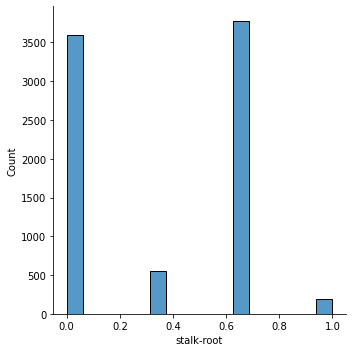

In [60]:
sns.displot(df_knn_norm['stalk-root'])

#### Imputación por moda de clase

Ya que la imputación por KNN no funciono se intenta por la imputación por moda de clase 

In [61]:
index_clas_p = np.where(df['class'] == 'p')
index_clas_e = np.where(df['class'] == 'e')

In [62]:
df_clase_p = df.iloc[index_clas_p[0]]
df_clase_e = df.iloc[index_clas_e[0]]
imp_p = df_clase_p['stalk-root'].value_counts()
imp_e = df_clase_e['stalk-root'].value_counts()

print(imp_p)
print(imp_e)

b    1856
e     256
c      44
Name: stalk-root, dtype: int64
b    1920
e     864
c     512
r     192
Name: stalk-root, dtype: int64


Como en ambas clases los valores que más se repiten es la observación b los valores, los valores faltantes se cambiaran por dicha observación. Que sería igual a la imputación por moda.

In [63]:
df_moda = df.copy()
df_moda['stalk-root'] = df_moda['stalk-root'].fillna('b')

Se analíza la imputación realizada.

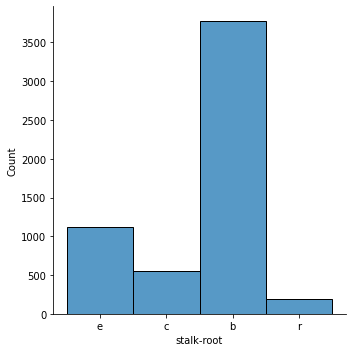

In [64]:
sns.displot(df['stalk-root'])

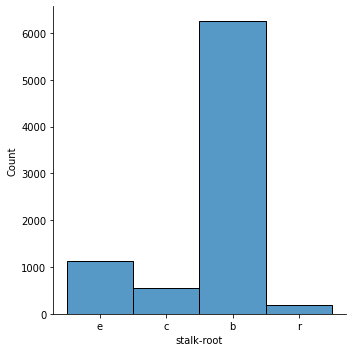

In [65]:
sns.displot(df_moda['stalk-root'])

### PCA

Se realiza un PCA para saber cuales son los atributos que nos brindan mayor información

In [66]:
df_pca = df_n_norm.drop(['class'], axis = 1)
df_pca -= df_pca.mean()
df_pca.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,-0.327523,-0.323978,-0.232617,-0.584441,-0.448671,-0.025849,-0.161497,-0.690793,-0.388568,-0.567208,...,-0.220253,-0.331528,-0.14371,-0.132693,-0.012802,-0.041359,-0.174052,-0.275111,-0.537568,-0.465780
1,-0.327523,-0.323978,-0.121506,-0.584441,-0.323671,-0.025849,-0.161497,0.309207,-0.388568,-0.567208,...,-0.220253,-0.331528,-0.14371,-0.132693,-0.012802,-0.041359,-0.174052,-0.150111,-0.337568,-0.299114
2,-0.127523,-0.323978,-0.010394,-0.584441,-0.198671,-0.025849,-0.161497,0.309207,-0.297659,-0.567208,...,-0.220253,-0.331528,-0.14371,-0.132693,-0.012802,-0.041359,-0.174052,-0.150111,-0.337568,-0.132447
3,-0.327523,0.009355,-0.010394,-0.584441,-0.448671,-0.025849,-0.161497,-0.690793,-0.297659,-0.567208,...,-0.220253,-0.331528,-0.14371,-0.132693,-0.012802,-0.041359,-0.174052,-0.275111,-0.537568,-0.465780
4,-0.327523,-0.323978,0.100717,0.415559,-0.073671,-0.025849,0.838503,0.309207,-0.388568,0.432792,...,-0.220253,-0.331528,-0.14371,-0.132693,-0.012802,-0.041359,0.075948,-0.150111,-0.137568,-0.299114


In [67]:
m_covarianza = matriz_covarianza(df_pca)

In [68]:
L, V = np.linalg.eig(m_covarianza)
porcentajes = (L / L.sum()) * 100
for col, por in zip(columnas[1:], porcentajes):
  print(f'{col}: {por}')

cap-shape: 27.33131629439478
cap-surface: 19.116313398009613
cap-color: 13.811856127134503
bruises: 8.944489167827191
odor: 6.278821265690815
gill-attachment: 4.960805125956759
gill-spacing: 3.73645496039574
gill-size: 2.8141949653051843
gill-color: 2.6157152649091286
stalk-shape: 1.8624035422528316
stalk-root: 1.7419561370568812
stalk-surface-above-ring: 1.392171726558767
stalk-surface-below-ring: 1.2151064285251587
stalk-color-above-ring: 1.1125928392614262
stalk-color-below-ring: 0.07656254940670525
veil-color: 0.21498303357773432
ring-number: 0.282237018154296
ring-type: 0.7879038696485183
spore-print-color: 0.47117519142587877
population: 0.6488169142540722
habitat: 0.5841241802540197


Se realiza una suma de n número de atributos que contribuyen con más información para clasificar los hogos.

In [69]:
np.sum(porcentajes[0:9])

89.60996656962371

In [70]:
np.sum(porcentajes[0:6])

80.44360137901364

Se realiza un analisis de PCA con la base de datos original,antes de realizar la imputación, para saber si los valores de porcentaje de información cambian por debido a la imputación.

In [71]:
df_pca = df_train_imputar.drop(['class'], axis = 1)
df_pca -= df_pca.mean()
df_pca.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,-0.27725,-0.386960,-0.232459,-0.435861,-0.378987,-0.003189,-0.181432,-0.875266,-0.277495,-0.510276,...,-0.194189,-0.291991,-0.132442,-0.127923,-0.001417,-0.017009,-0.15769,-0.170978,-0.514387,-0.371368
1,-0.27725,-0.386960,-0.121348,-0.435861,-0.253987,-0.003189,-0.181432,0.124734,-0.277495,-0.510276,...,-0.194189,-0.291991,-0.132442,-0.127923,-0.001417,-0.017009,-0.15769,-0.045978,-0.314387,-0.204701
2,-0.07725,-0.386960,-0.010237,-0.435861,-0.128987,-0.003189,-0.181432,0.124734,-0.186586,-0.510276,...,-0.194189,-0.291991,-0.132442,-0.127923,-0.001417,-0.017009,-0.15769,-0.045978,-0.314387,-0.038034
3,-0.27725,-0.053626,-0.010237,-0.435861,-0.378987,-0.003189,-0.181432,-0.875266,-0.186586,-0.510276,...,-0.194189,-0.291991,-0.132442,-0.127923,-0.001417,-0.017009,-0.15769,-0.170978,-0.514387,-0.371368
4,-0.27725,-0.386960,0.100874,0.564139,-0.003987,-0.003189,0.818568,0.124734,-0.277495,0.489724,...,-0.194189,-0.291991,-0.132442,-0.127923,-0.001417,-0.017009,0.09231,-0.045978,-0.114387,-0.204701


In [72]:
m_covarianza = matriz_covarianza(df_pca)

In [73]:
L, V = np.linalg.eig(m_covarianza)
porcentajes = (L / L.sum()) * 100
for col, por in zip(columnas[1:], porcentajes):
  print(f'{col}: {por}')

cap-shape: 37.05355803765021
cap-surface: 19.47601531310546
cap-color: 14.233990258464713
bruises: 6.611456693424127
odor: 5.225146073849783
gill-attachment: 3.404196603639504
gill-spacing: 2.749174442501957
gill-size: 2.1728129003900856
gill-color: 1.846506681987019
stalk-shape: 1.4883975583761133
stalk-root: 1.340683456352985
stalk-surface-above-ring: 1.2635620199958801
stalk-surface-below-ring: 0.885047701869876
stalk-color-above-ring: 0.6403216530471578
stalk-color-below-ring: 0.49388557078118955
veil-color: 0.42701964717774976
ring-number: 0.2792079209573595
ring-type: 0.15817729319928148
spore-print-color: 0.051511615515568925
population: 0.09079937945633411
habitat: 0.10852917825765208


In [74]:
np.sum(porcentajes[0:9])

92.77285700501287

Después de realizar un análisis de componentes principales se determino que solo se iban a trabajar con los siguientesatributos:
* cap-shape
* cap-surface
* cap-color
* bruises
* odor
* gill-attachment
* gill-spacing
* gill-size
* gill-color

Como se puede observar, el atributo en el cual se realizó la imputación no será ocupado para la clasificación, de forma que la imputación no sesgará la clasificación.

In [75]:
x_clasificar = np.asarray(df[columnas[1:10]])
y_clasificar = np.asarray(df['class'])
x_norm_clasificar = np.asarray(df_n_norm[columnas[1:10]])
y_norm_clasificar = np.asarray(df_n_norm['class'])
x_n_clasificar = np.asarray(df_n[columnas[1:10]])
y_n_clasificar = np.asarray(df_n['class'])

In [76]:
x_clasificar_df = df[columnas[1:10]]
y_clasificar_df = df['class']

## Clasificación

In [77]:
x_train, x_test, y_train, y_test = split_80_20(x_clasificar, y_clasificar)
x_train_norm, x_test_norm, y_train_norm, y_test_norm = split_80_20(x_norm_clasificar, y_norm_clasificar)
x_train_n, x_test_n, y_train_n, y_test_n = split_80_20(x_n_clasificar, y_n_clasificar)

In [78]:
x_train_df, x_test_df, y_train_df, y_test_df = split_80_20_df(x_clasificar_df, y_clasificar_df)

#### MLP

In [79]:
# Funciones de activación
sigmoide = lambda x: 1 / (1 + np.e ** (-x))
sigmoide_derivada = lambda x: x * (1 - x)
relu = lambda x: x if x > 0 else 0
relu_derivada = lambda x: 0 if x <= 0 else x

In [80]:
# Funciones de coste
l2 = lambda y, y1: np.mean((y - y1) ** 2)
l2_derivada = lambda y, y1: (y - y1)

In [81]:
learning_rate = 5e-2
epocas_entrenamiento = 30000
neuronas_por_capa = [9, 6, 3, 2]

In [82]:
y_mlp_train = to_categorical(y_train_norm)

In [98]:
y_mlp_test = to_categorical(y_test_norm)

In [83]:
y_mlp_train

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [84]:
red_neuronal = compilar_red(neuronas_por_capa, sigmoide)

##### Entrenamineto

In [85]:
historial_l2 = []
for i in tqdm(range(epocas_entrenamiento)):
  y_entrenamiento_1 = entrenar_red(x_train_norm, y_mlp_train, red_neuronal, sigmoide_derivada,
                           l2_derivada)
  historial_l2.append(l2(y_entrenamiento_1, y_mlp_train))

100%|██████████| 30000/30000 [04:49<00:00, 103.71it/s]


In [86]:
y_entrenamiento_1 = np.round(y_entrenamiento_1)

In [87]:
num_errores, por100 = precision_mlp(y_entrenamiento_1, y_mlp_train)
print(f'Se obtuvo {100-por100}% de precisión con un total de {num_errores} errores.')

Se obtuvo 69.04615384615384% de precisión con un total de 2012 errores.


<function matplotlib.pyplot.show>

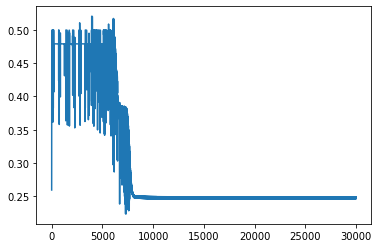

In [88]:
plt.plot(historial_l2)
plt.show

In [97]:
y_predict_m = predecir(x_test_norm, red_neuronal)
np.round(y_predict_m)

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [99]:
num_errores, por100 = precision_mlp(y_predict_m, y_mlp_test)
print(f'Se obtuvo {100-por100}% de precisión con un total de {num_errores} errores.')

Se obtuvo 66.7487684729064% de precisión con un total de 540 errores.


#### KNN

##### Entrenamiento

In [89]:
e, me, mv = entrenamiento_KNN(x_train_n, y_train_n, 30)
print(f'''La mejor exactitud se obtiene con {mv} vecinos.
Con una exactitud de {me}''')

100%|██████████| 28/28 [2:01:01<00:00, 259.35s/it]

La mejor exactitud se obtiene con 4 vecinos.
Con una exactitud de 0.9969230769230769


Text(0, 0.5, 'Exactitud')

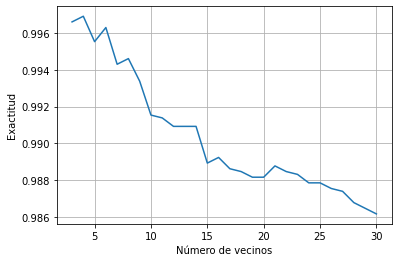

In [90]:
plt.figure()
plt.plot(np.arange(3, 31), e)
plt.grid(True)
plt.xlabel('Número de vecinos')
plt.ylabel('Exactitud')

In [103]:
y_clas_train_knn = clasificar_KNN(x_train_n, x_train_n, y_train_n, mv)

100%|██████████| 6500/6500 [05:27<00:00, 19.86it/s]


In [104]:
exactitud_train = exactitud(y_clas_train_knn, y_train_n)
error_cuad_train = MSE(y_train_n, y_clas_train_knn)
precision_train = precision(y_clas_train_knn, y_train_n)
sensitividad_train = sensitividad(y_clas_train_knn, y_train_n)
especificidad_train = especificidad (y_clas_train_knn, y_train_n)
f1_train = puntaje_F1(y_clas_train_knn, y_train_n)

In [105]:
print(f'''La evaluación del entrenamiento del modelo diseñado nos indica que se tienen las siguientes cifras de mérito:
Exactitud: {exactitud_train}
Precisión: {precision_train}
Sensitividad: {sensitividad_train}
Especificidad: {especificidad_train}
Puntaje F1: {f1_train}
Error cuadrático medio: {error_cuad_train}''')

La evaluación del entrenamiento del modelo diseñado nos indica que se tienen las siguientes cifras de mérito:
Exactitud: 0.9969230769230769
Precisión: 0.9955778301886793
Sensitividad: 0.9985215848610289
Especificidad: 0.9951892238614497
Puntaje F1: 0.9970475346914673
Error cuadrático medio: 0.0015384615384615385


##### Clasificar

In [91]:
y_clas_knn = clasificar_KNN(x_test_n, x_train_n, y_train_n, mv)

100%|██████████| 1624/1624 [01:08<00:00, 23.80it/s]


In [92]:
exactitud_test = exactitud(y_clas_knn, y_test_n)
error_cuad_test = MSE(y_test_n, y_clas_knn)
precision_test = precision(y_clas_knn, y_test_n)
sensitividad_test = sensitividad(y_clas_knn, y_test_n)
especificidad_test = especificidad (y_clas_knn, y_test_n)
f1_test = puntaje_F1(y_clas_knn, y_test_n)

##### Evaluación

In [93]:
print(f'''La evaluación del modelo diseñado nos indica que se tienen las siguientes cifras de mérito:
Exactitud: {exactitud_test}
Precisión: {precision_test}
Sensitividad: {sensitividad_test}
Especificidad: {especificidad_test}
Puntaje F1: {f1_test}
Error cuadrático medio: {error_cuad_test}''')

La evaluación del modelo diseñado nos indica que se tienen las siguientes cifras de mérito:
Exactitud: 0.9932266009852216
Precisión: 0.9903730445246691
Sensitividad: 0.9963680387409201
Especificidad: 0.9899749373433584
Puntaje F1: 0.9933614966807484
Error cuadrático medio: 0.0033866995073891628


#### ID3

In [94]:
clases = y_train_df.unique()

##### Entrenamiento

In [95]:
arbol_hongo = {}
arbol_hongo = arbol_id3(x_train_df, y_train_df, clases, arbol_hongo)

RecursionError: ignored

Debido a las características de la base de datos no es posible clasificar los hongos con este tipo de árbol de decisión.

### Conclusión

El modelo de KNN fue el algoritmo que más se acoplo a la base de datos, teniendo un buen rendimiento, los cual se puede ver en sus cifras de mérito.